In [1]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner

import jax
import jax.numpy as jnp
import numpyro

## deltas

In [2]:
loc = 0
scale = 0.3
true = numpyro.distributions.TruncatedNormal(
    loc = loc, scale = scale, low = 0, high = 1,
)

In [3]:
n = 50
events = true.sample(jax.random.PRNGKey(0), (n,))
events.shape

(50,)

(array([2.52, 2.7 , 2.34, 0.54, 0.54, 0.36, 0.  , 0.  , 0.  ]),
 array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 [<matplotlib.patches.Polygon at 0x7f0b9c6bfd50>])

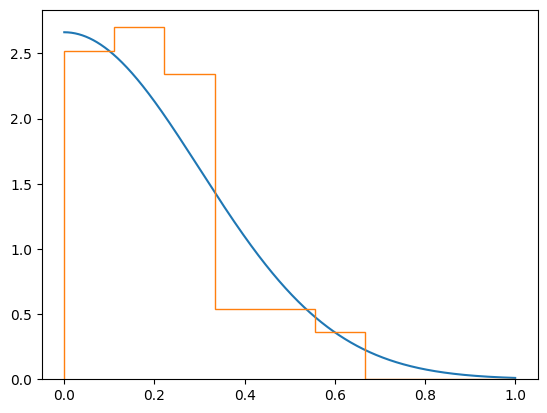

In [4]:
x = jnp.linspace(0, 1, 1_000)
y = jnp.exp(true.log_prob(x))
plt.plot(x, y)
plt.hist(
    events, bins = np.linspace(0, 1, 10), density = True, histtype = 'step',
)

In [5]:
def model(events):
    loc = numpyro.sample('loc', numpyro.distributions.Uniform(-0.3, 0.5))
    scale = numpyro.sample('scale', numpyro.distributions.Uniform(0.05, 0.7))
    with numpyro.plate('events', events.size):
        numpyro.sample(
            'obs',
            numpyro.distributions.TruncatedNormal(
                loc = loc, scale = scale, low = 0, high = 1,
            ),
            obs = events,
        )

In [6]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 10_000, num_samples = 10_000)
mcmc.run(jax.random.PRNGKey(1), events)
mcmc.print_summary()

sample: 100%|█████| 20000/20000 [00:09<00:00, 2083.64it/s, 3 steps of size 2.98e-01. acc. prob=0.80]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       loc     -0.02      0.13     -0.00     -0.24      0.18   1578.66      1.00
     scale      0.27      0.06      0.26      0.17      0.36   1545.12      1.00

Number of divergences: 0


In [7]:
samples = np.transpose([mcmc.get_samples()[par] for par in ('loc', 'scale')])

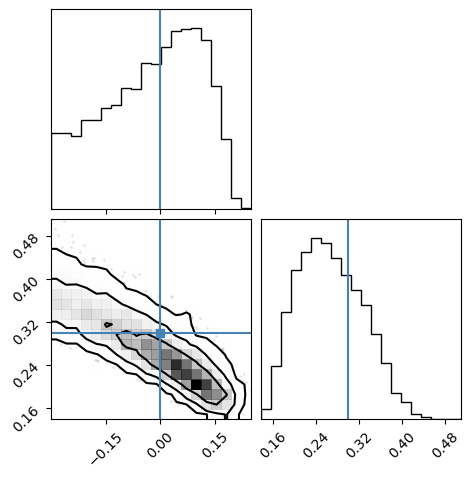

In [8]:
corner(samples, truths = [loc, scale], levels = [0.5, 0.9, 0.99]);

## fake likelihood

In [2]:
loc = 0
scale = 0.3

true = numpyro.distributions.TruncatedNormal(
    loc = loc, scale = scale, low = 0, high = 1,
)

In [38]:
n_obs = 10_000

locs = true.sample(jax.random.PRNGKey(0), (n_obs,))

scales = jax.random.uniform(
    jax.random.PRNGKey(1), (n_obs,), minval = 0.2, maxval = 1,
)

likelihoods = numpyro.distributions.TruncatedNormal(
    loc = locs, scale = scales, low = 0, high = 1,
)

obs = likelihoods.sample(jax.random.PRNGKey(2))

In [39]:
def model():
    loc = numpyro.sample('loc', numpyro.distributions.Uniform(-0.3, 0.5))
    scale = numpyro.sample('scale', numpyro.distributions.Uniform(0.05, 0.7))
    
    with numpyro.plate('n_obs', n_obs):
        locs = numpyro.sample(
            'locs',
            numpyro.distributions.TruncatedNormal(
                loc = loc, scale = scale, low = 0, high = 1,
            ),
        )
        likelihoods = numpyro.distributions.TruncatedNormal(
            loc = locs, scale = scales, low = 0, high = 1,
        )
        numpyro.sample('obs', likelihoods, obs = obs)

In [40]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 1_000, num_samples = 1_000)
mcmc.run(jax.random.PRNGKey(3))
mcmc.print_summary()

sample: 100%|███████| 2000/2000 [06:59<00:00,  4.77it/s, 127 steps of size 2.43e-02. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       loc     -0.10      0.11     -0.10     -0.28      0.06     18.29      1.00
   locs[0]      0.25      0.19      0.21      0.00      0.53   1507.49      1.00
   locs[1]      0.18      0.15      0.15      0.00      0.38   1438.09      1.01
   locs[2]      0.13      0.11      0.09      0.00      0.29   1402.34      1.00
   locs[3]      0.18      0.14      0.15      0.00      0.39   1316.90      1.00
   locs[4]      0.33      0.19      0.31      0.00      0.61   1555.57      1.00
   locs[5]      0.27      0.20      0.23      0.00      0.56   1221.15      1.00
   locs[6]      0.24      0.18      0.20      0.00      0.48   1007.33      1.00
   locs[7]      0.22      0.19      0.18      0.00      0.50   1267.42      1.00
   locs[8]      0.26      0.19      0.22      0.00      0.54   1253.72      1.00
   locs[9]      0.24      0.18      0.20      0.00      0.50   1504.12      1.00
  locs[10]      0.32      0

In [41]:
samples = np.transpose([mcmc.get_samples()[par] for par in ('loc', 'scale')])

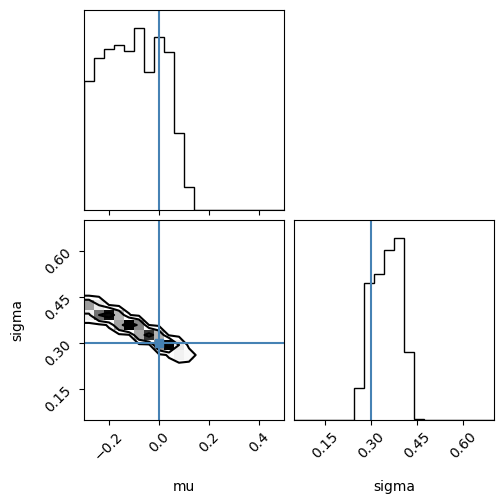

In [42]:
corner(
    samples,
    levels = [0.5, 0.9, 0.99],
    labels = ['mu', 'sigma'],
    truths = [loc, scale],
    range = [[-0.3, 0.5], [0.05, 0.7]],
);